# This Jupyter Notebook contains code that accompanies Allison Honold's Medium Blog Post
## Binning Records on a Continuous Variable with Pandas Cut and QCut: When, why, and how to transform a numeric feature into a categorical feature

In [2]:
# import necessary packages
import pandas as pd
from sodapy import Socrata
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random

In [3]:
# import data

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.seattle.gov", None)
results = client.get("k9m8-nhz3", limit=1000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [4]:
# this data set is City of Seattle Wages: Comparison by Gender –Wage Progression Job Titles
# https://data.seattle.gov/City-Business/City-of-Seattle-Wages-Comparison-by-Gender-Wage-Pr/k9m8-nhz3

df.head()

,job_classification,female_avg_hrly_rate,no_female_empl,male_avg_hrly_rate,no_male_empl,total_avg_hrly_rate,total_no_empl,female_to_male_rate,female_to_male_count,notes
0,Accountant,30.58,23,30.28,7,30.51,30,101,329,NaN
1,"Accountant,Prin",38.75,23,37.64,7,38.49,30,103,329,NaN
2,"Accountant,Sr",34.479999999999997,23,33.89,6,34.36,29,102,383,NaN
3,Act Exec,43.1,4,42.02,7,42.42,11,103,57,NaN
4,Actg Tech I,22.56,1,NaN,NaN,22.56,1,NaN,NaN,no men in title


In [5]:
# fill NaN with 0
df = df.fillna(0)

# cast numeric strings as floats
cols = df.columns.drop(['job_classification', 'notes'])
df[cols] = df[cols].astype(float)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   job_classification    759 non-null    object 
 1   female_avg_hrly_rate  759 non-null    float64
 2   no_female_empl        759 non-null    float64
 3   male_avg_hrly_rate    759 non-null    float64
 4   no_male_empl          759 non-null    float64
 5   total_avg_hrly_rate   759 non-null    float64
 6   total_no_empl         759 non-null    float64
 7   female_to_male_rate   759 non-null    float64
 8   female_to_male_count  759 non-null    float64
 9   notes                 759 non-null    object 
dtypes: float64(8), object(2)
memory usage: 59.4+ KB


In [7]:
df.head(100)

,job_classification,female_avg_hrly_rate,no_female_empl,male_avg_hrly_rate,no_male_empl,total_avg_hrly_rate,total_no_empl,female_to_male_rate,female_to_male_count,notes
0,Accountant,30.58,23.0,30.28,7.0,30.51,30.0,101.0,329.0,0
1,"Accountant,Prin",38.75,23.0,37.64,7.0,38.49,30.0,103.0,329.0,0
2,"Accountant,Sr",34.48,23.0,33.89,6.0,34.36,29.0,102.0,383.0,0
3,Act Exec,43.10,4.0,42.02,7.0,42.42,11.0,103.0,57.0,0
4,Actg Tech I,22.56,1.0,0.00,0.0,22.56,1.0,0.0,0.0,no men in title
...,...,...,...,...,...,...,...,...,...,...
95,"Cashier,Sr",19.38,3.0,18.74,1.0,19.22,4.0,103.0,300.0,0
96,Cblspl Aprn,0.00,0.0,31.68,4.0,31.68,4.0,0.0,0.0,no women in title
97,Cblspl CC-Asg C Coord,0.00,0.0,46.28,2.0,46.28,2.0,0.0,0.0,no women in title
98,Cblspl CC-Asg Locator,46.28,1.0,0.00,0.0,46.28,1.0,0.0,0.0,no men in title


# Ungrouped Data

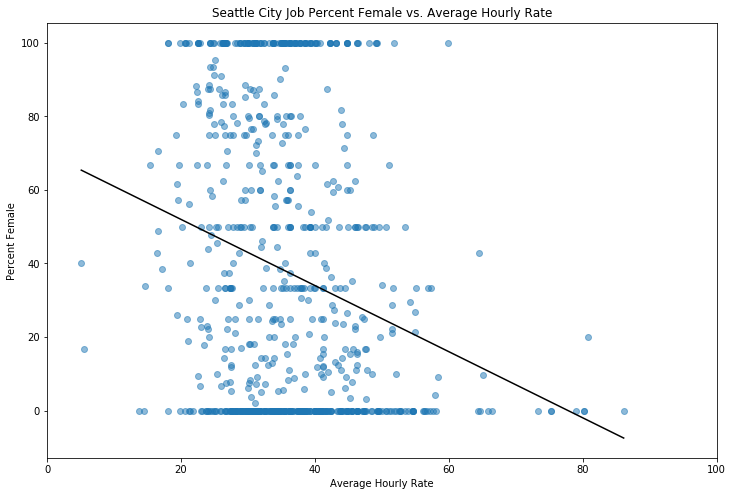

In [8]:
df['pct_female'] = df['no_female_empl'] / df['total_no_empl'] *100
x = df['total_avg_hrly_rate']
y = df['pct_female']
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.xlim(0, 100)
plt.scatter(x, y, alpha=.5)
plt.title('Seattle City Job Percent Female vs. Average Hourly Rate')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black')

In [9]:
fig.tight_layout()
fig.savefig('./images/ungrouped.png')

In [10]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

In [11]:
rvalue*rvalue

0.05626259742864942

In [12]:
stats.linregress(x, y)

LinregressResult(slope=-0.8990590942204966, intercept=69.9494449637719, rvalue=-0.23719738073732902, pvalue=3.6239874781586534e-11, stderr=0.13383077514829939)

# Grouping job titles by total average hourly rate

In [13]:
df['pay_grp_cut_n'] = pd.cut(df['total_avg_hrly_rate'], 5)

In [14]:
df.head().T

,0,1,2,3,4
job_classification,Accountant,"Accountant,Prin","Accountant,Sr",Act Exec,Actg Tech I
female_avg_hrly_rate,30.58,38.75,34.48,43.1,22.56
no_female_empl,23,23,23,4,1
male_avg_hrly_rate,30.28,37.64,33.89,42.02,0
no_male_empl,7,7,6,7,0
total_avg_hrly_rate,30.51,38.49,34.36,42.42,22.56
total_no_empl,30,30,29,11,1
female_to_male_rate,101,103,102,103,0
female_to_male_count,329,329,383,57,0
notes,0,0,0,0,no men in title


In [16]:
# get sums within group - esp for employee counts
grouped = df.groupby(df['pay_grp_cut_n'], as_index=False).sum()

In [17]:
grouped

,pay_grp_cut_n,female_avg_hrly_rate,no_female_empl,male_avg_hrly_rate,no_male_empl,total_avg_hrly_rate,total_no_empl,female_to_male_rate,female_to_male_count,pct_female
0,"(5.029, 21.31]",466.47,144.0,432.81,214.0,573.30,358.0,1915.0,2474.0,1611.219837
1,"(21.31, 37.51]",9031.65,4930.0,10731.53,7785.0,13264.33,12715.0,21507.0,46092.0,18829.913167
2,"(37.51, 53.71]",6586.52,778.0,9657.71,2694.0,11212.65,3472.0,11493.0,9394.0,7736.969561
3,"(53.71, 69.91]",640.08,35.0,1565.93,173.0,1625.78,208.0,1002.0,356.0,343.692668
4,"(69.91, 86.11]",81.65,1.0,629.88,24.0,630.08,25.0,101.0,25.0,20.000000


In [18]:
df['pay_grp_cut_n'].value_counts().sort_index().reset_index()

,index,pay_grp_cut_n
0,"(5.029, 21.31]",32
1,"(21.31, 37.51]",433
2,"(37.51, 53.71]",258
3,"(53.71, 69.91]",28
4,"(69.91, 86.11]",8


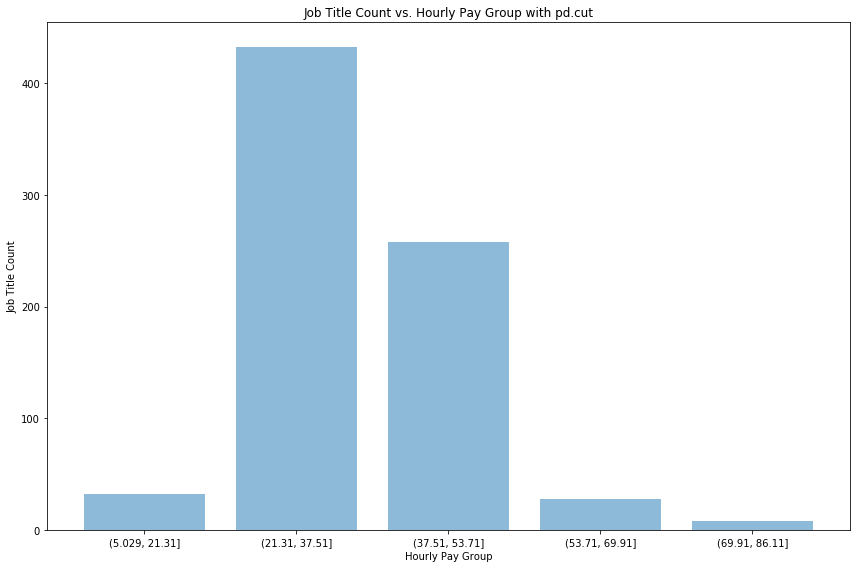

In [19]:
cut_counts = df['pay_grp_cut_n'].value_counts().sort_index().reset_index()

x = cut_counts['index'].astype(str)
y = cut_counts['pay_grp_cut_n']

fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Hourly Pay Group')
plt.ylabel('Job Title Count')
plt.title('Job Title Count vs. Hourly Pay Group with pd.cut')
plt.bar(x, y, alpha=.5)

fig.tight_layout()
fig.savefig('./images/cut5.png');

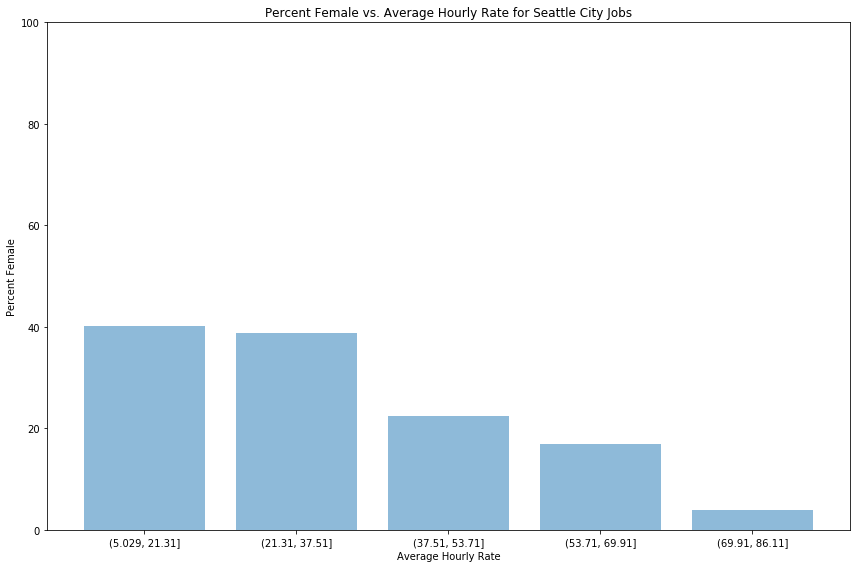

In [20]:
x = grouped['pay_grp_cut_n'].astype(str)
y = grouped['no_female_empl'] / grouped['total_no_empl'] *100
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.title('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
plt.ylim(0,100)
plt.bar(x, y, alpha=.5)
fig.tight_layout()
fig.savefig('./images/cut5_pct_female');

## labels

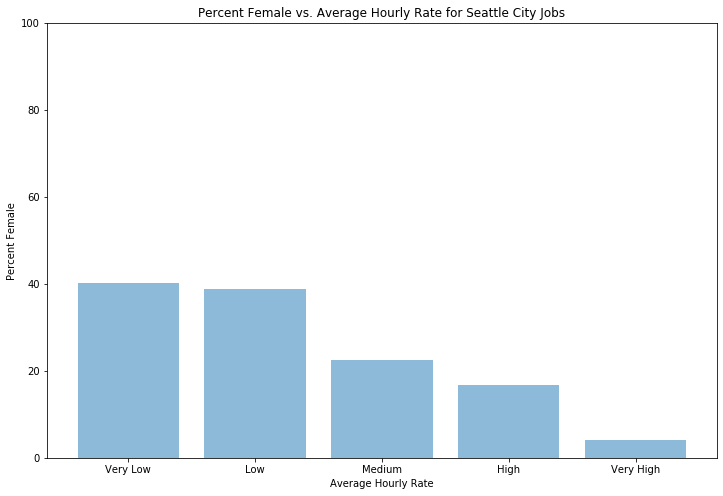

In [32]:
df['pay_grp_cut_l'] = pd.cut(df['total_avg_hrly_rate'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
grouped1 = df.groupby(df['pay_grp_cut_l'], as_index=False).sum()
x1 = grouped1['pay_grp_cut_l']
y1 = grouped1['no_female_empl'] / grouped1['total_no_empl'] *100
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.title('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
plt.ylim(0,100)
plt.bar(x1, y1, alpha=.5);

In [22]:
for grp in df['pay_grp_cut_l'].unique():
    a = df.loc[df['pay_grp_cut_l'] == grp, 'pct_female']
    b = df.loc[df['pay_grp_cut_l'] != grp, 'pct_female']
    if len(a) < len(b):
        print(grp, '\n', stats.ttest_ind(a, random.sample(list(b), len(a))))
    if len(b) < len(a):
        print(grp, '\n', stats.ttest_ind(b, random.sample(list(a), len(b))))

Low 
 Ttest_indResult(statistic=-4.51050133075541, pvalue=7.674220758165174e-06)
Medium 
 Ttest_indResult(statistic=-3.058629424558148, pvalue=0.0023394509803471124)
Very Low 
 Ttest_indResult(statistic=1.6010308463712921, pvalue=0.11445362155638761)
Very High 
 Ttest_indResult(statistic=-2.3719501183053397, pvalue=0.03257032845192342)
High 
 Ttest_indResult(statistic=-3.2374701494360276, pvalue=0.002063604729787673)


## Choose Group Boundaries (x-axis)

In [30]:
df['pay_grp_cut_set_boundaries'] = pd.cut(df['total_avg_hrly_rate'], [5,20,35,50,65,80])

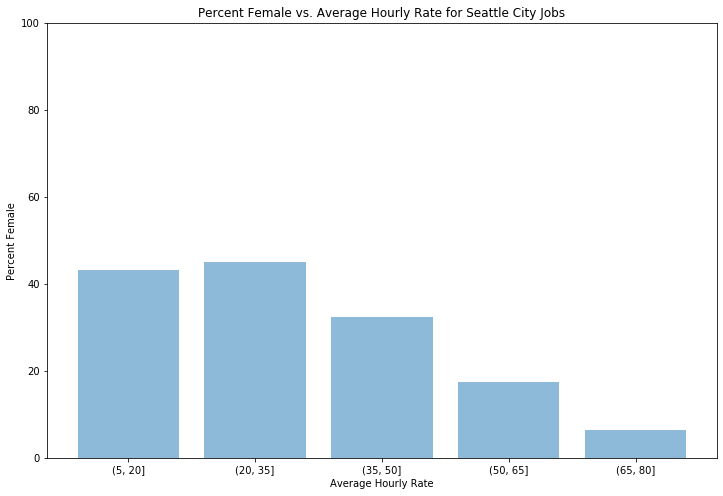

In [33]:
grouped2 = df.groupby(df['pay_grp_cut_set_boundaries'], as_index=False).sum()
x2 = grouped2['pay_grp_cut_set_boundaries'].astype(str)
y2 = grouped2['no_female_empl'] / grouped['total_no_empl'] *100
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.title('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
plt.ylim(0,100)
plt.bar(x2, y2, alpha=.5);

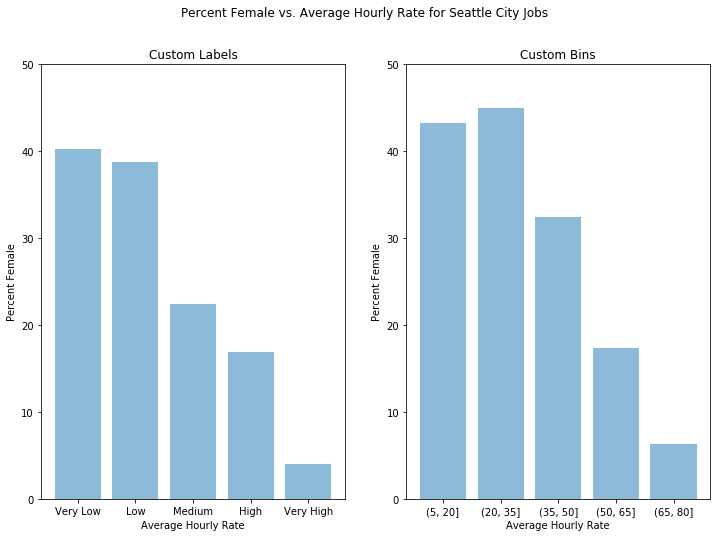

In [48]:
# graph for blog

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_xlabel('Average Hourly Rate')
axs[1].set_xlabel('Average Hourly Rate')
axs[0].set_ylabel('Percent Female')
axs[1].set_ylabel('Percent Female')
fig.suptitle('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
axs[0].set_ylim(0,50)
axs[1].set_ylim(0,50)
axs[0].set_title('Custom Labels')
axs[1].set_title('Custom Bins')
axs[0].bar(x1, y1, alpha=.5)
axs[1].bar(x2, y2, alpha=.5)
fig.savefig('./images/custom_bins.png');

## Even Volume Groups

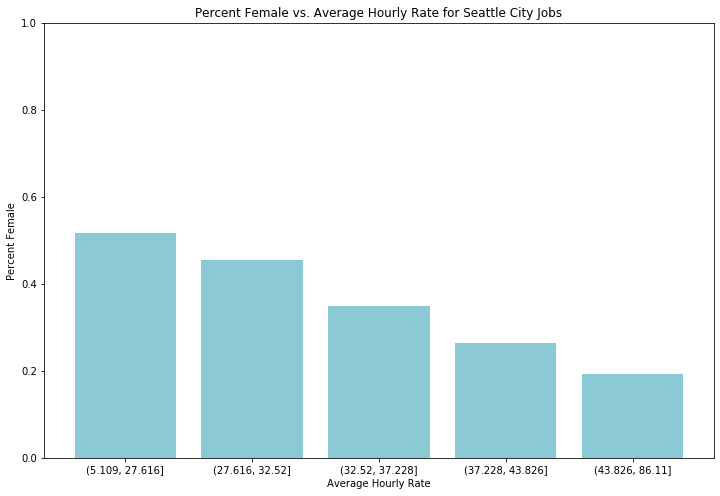

In [53]:
df['pay_grp_qcut_n'] = pd.qcut(df['total_avg_hrly_rate'], 5)
grouped = df.groupby(df['pay_grp_qcut_n'], as_index=False).sum()
x = [str(x) for x in grouped['pay_grp_qcut_n']]
y = grouped['no_female_empl'] / grouped['total_no_empl']
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.title('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
plt.ylim(0,1)
plt.bar(x, y, alpha=.5, color='#1896ac')
fig.savefig('./images/qcut_5_bins.png');

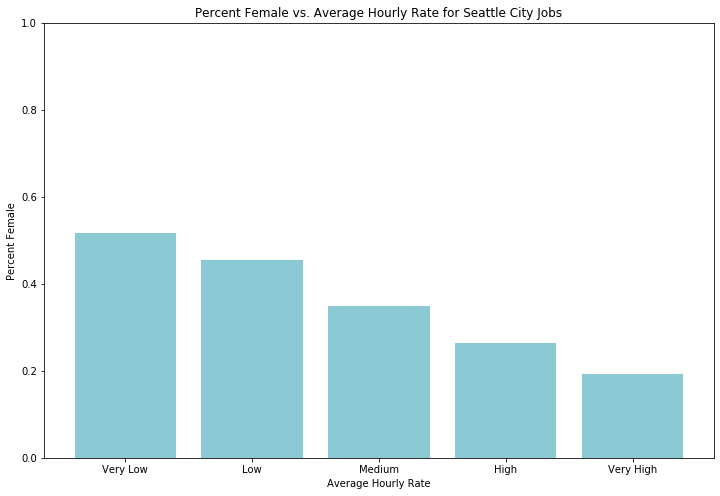

In [54]:
df['pay_grp_qcut_l'] = pd.qcut(df['total_avg_hrly_rate'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
grouped = df.groupby(df['pay_grp_qcut_l'], as_index=False).sum()
x = grouped['pay_grp_qcut_l']
y = grouped['no_female_empl'] / grouped['total_no_empl']
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel('Average Hourly Rate')
plt.ylabel('Percent Female')
plt.title('Percent Female vs. Average Hourly Rate for Seattle City Jobs')
plt.ylim(0,1)
plt.bar(x, y, alpha=.5, color='#1896ac');

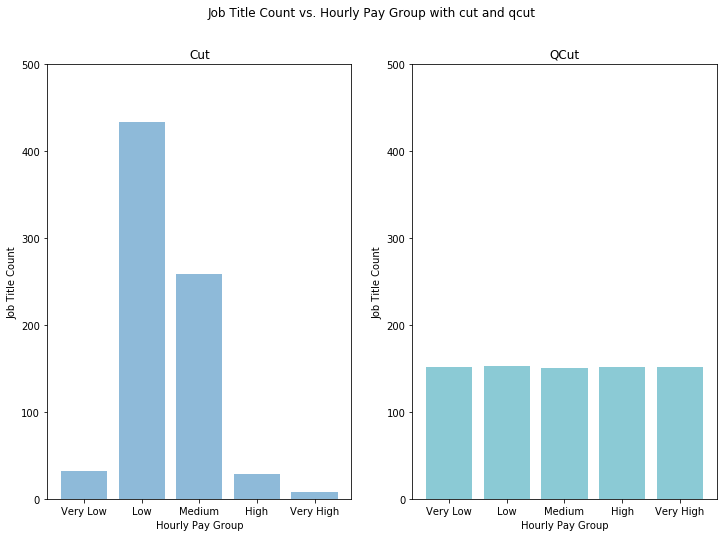

In [59]:
qcut_counts = df['pay_grp_qcut_l'].value_counts().sort_index().reset_index()
cut_counts = df['pay_grp_cut_l'].value_counts().sort_index().reset_index()

x1 = cut_counts['index'].astype(str)
y1 = cut_counts['pay_grp_cut_l']

x2 = qcut_counts['index'].astype(str)
y2 = qcut_counts['pay_grp_qcut_l']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_xlabel('Hourly Pay Group')
axs[1].set_xlabel('Hourly Pay Group')
axs[0].set_ylabel('Job Title Count')
axs[1].set_ylabel('Job Title Count')
fig.suptitle('Job Title Count vs. Hourly Pay Group with cut and qcut')
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[0].set_title('Cut')
axs[1].set_title('QCut')
axs[1].bar(x2, y2, alpha=.5, color='#1896ac')
axs[0].bar(x1, y1, alpha=.5)
fig.savefig('./images/cut_qcut_counts.png');